# TIRESIA - Agglomerative Clustering

In [ ]:
# library
from scipy.cluster.hierarchy import single, cophenet
from scipy.spatial.distance import pdist, squareform
import pandas as pd
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
import numpy as np
import csv
import networkx as nx

from collections import defaultdict
from sklearn.metrics import silhouette_score, davies_bouldin_score

In [ ]:
# open file csv and save to a dataframe

personal_path = "/anon_bookings_history.csv"

bh = pd.read_csv(personal_path, parse_dates=['created_at'], date_parser=pd.to_datetime)

In [ ]:
# explnation of rows
bh.head()

,userid,libraryid,seatid,created_at,action,actionfrom
0,4356,2,4,2019-11-14 05:28:05,reserve,user
1,4356,2,4,2019-11-14 05:28:08,cancel,user
2,2742,2,8,2019-11-14 05:41:58,reserve,user
3,2742,2,8,2019-11-14 05:42:02,cancel,user
4,2742,2,1,2019-11-14 05:43:20,reserve,user


In [ ]:
# clean dataset
bh = bh[bh.actionfrom == 'user'][['userid', 'libraryid', 'seatid', 'created_at', 'action']]

# gamlab dataset --> 1st ds for testing
gl = bh[(bh.libraryid == 1) & (bh.created_at <= '2019-12-21 19:00:00') & (bh.created_at.dt.time >= pd.to_datetime('8:35:00').time()) & (bh.created_at.dt.time <= pd.to_datetime('19:00:00').time())].reset_index(drop=True)

# betatesting in Boaga --> 2nd ds for testing
bt = bh[(bh.libraryid == 2) & (bh.created_at <= '2019-12-23 19:00:00')].reset_index(drop=True)

## Dataset elaboration

### Feature selection and transformation

In [ ]:
day = lambda c : [x.day for x in c]

month = lambda c : [x.month for x in c]

def groupSeat(s, g_num):
    l = []
    
    seats = np.sort(np.unique(s.to_numpy()))

    g = {}
    for i in seats:
        g[i] = int((i / g_num) + (i % g_num))

    for x in s:
        l += [g[x]]
    return l

timeGap = lambda s, i : [ (x.hour*60 + x.minute)//i for x in s ]

def act(s):
    # action: string -> number
    l = []
    for v in s:
        if v == "reserve":
            l.append(1)
        elif v == "confirm":
            l.append(2)
        else:
            l.append(3)
    return l

In [ ]:
gl = bh[(bh.libraryid == 1)].reset_index(drop=True)
gl['day'] = day(gl['created_at'])
gl['month'] = month(gl['created_at'])
gl['groupSeat'] = groupSeat(gl['seatid'],3)
gl['timeGap'] = timeGap(gl['created_at'], 10)
gl['action'] = act(gl['action'])


# drop the users with less than 6 actions in the system

n_actions = gl["userid"].value_counts().to_dict()
matricole = list(n_actions.keys())

matr_toremove = [matr for matr in n_actions.keys() if n_actions[matr] <= 6]
print(len(gl))
gl.drop(gl[gl.userid.isin(matr_toremove)].index, inplace=True)
print(len(gl))

print("Users before the removing: " + str(len(matricole)))
print("Users remaning: " + str(len(matr_tokeep)))

885
875
Users before the removing: 30
Users remaning: 27


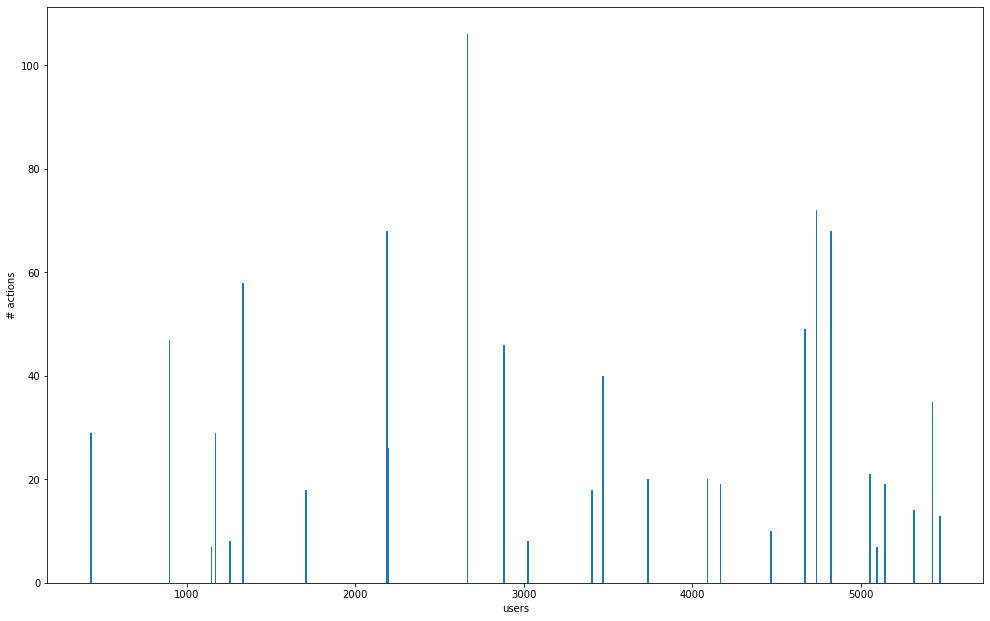

In [ ]:
fig = plt.figure(figsize=(13,8))
ax = fig.add_axes([0,0,1,1])

ax.bar(n_actions.keys(),n_actions.values(), width=10)
plt.xlabel('users')
plt.ylabel('# actions')
plt.show()

## Dendogram

Text(0, 0.5, 'Euclidean distance')

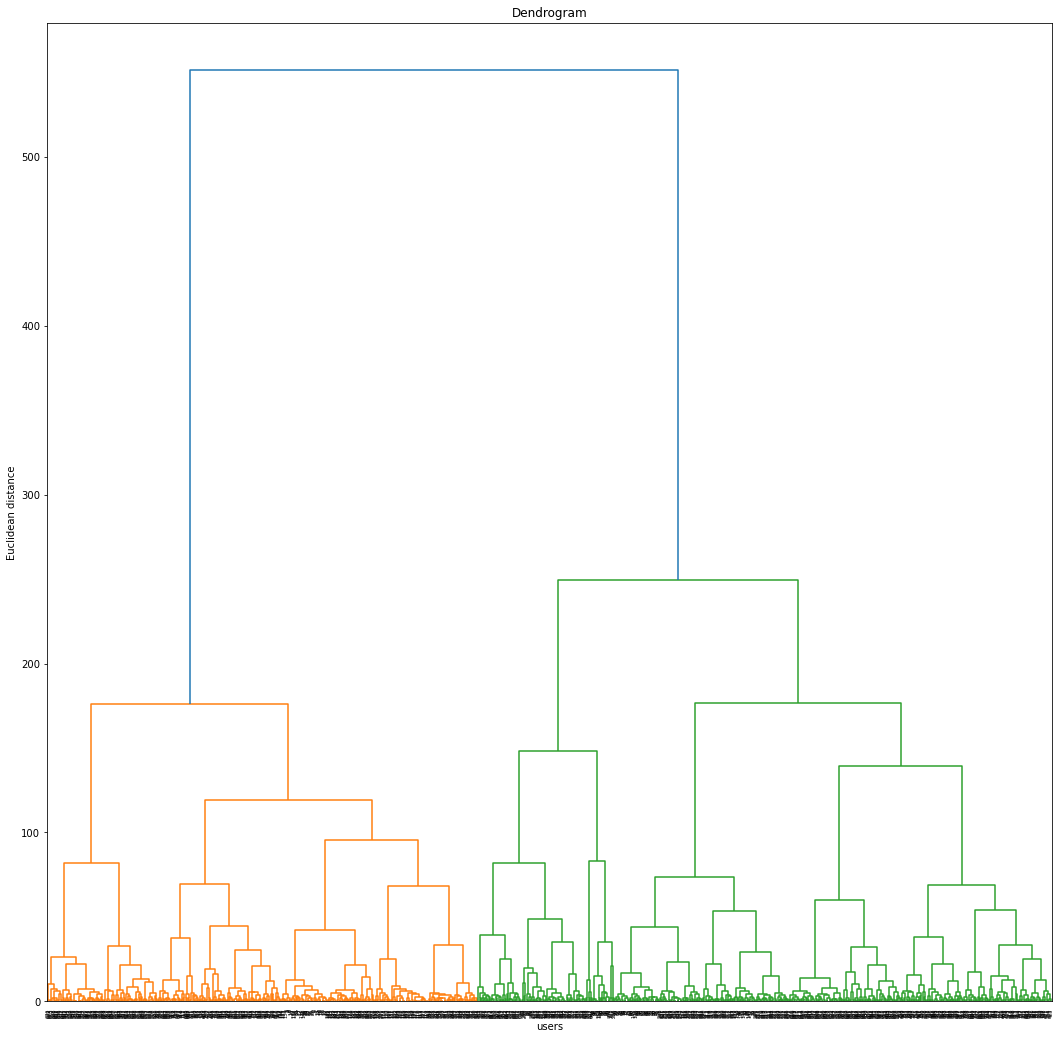

In [ ]:
plt.figure(figsize=(18,18))

X = gl.iloc[:, 4:9].values
Z = sch.linkage(X, method = 'ward')
dendrogrm = sch.dendrogram(Z)
plt.title('Dendrogram')
plt.xlabel('users')
plt.ylabel('Euclidean distance')

## Agglomerative Clustering

In [ ]:
hc = AgglomerativeClustering(n_clusters = None, affinity = 'euclidean', linkage = 'ward', distance_threshold = 200)
y_hc = hc.fit_predict(X)

In [ ]:
print(silhouette_score(X, y_hc))
print(davies_bouldin_score(X, y_hc))


print(cophenet(Z))

0.3520396406941632
1.107545585488963
[  1.           1.73205081  12.83793208 ... 551.6180485  551.6180485
   2.        ]


In [ ]:
gl['cluster'] = y_hc

gl.head()

,userid,libraryid,seatid,created_at,action,day,month,groupSeat,timeGap,cluster
0,1334,1,3,2019-12-05 10:54:08,1,5,12,1,65,1
1,1334,1,3,2019-12-05 10:57:05,2,5,12,1,65,1
2,1334,1,3,2019-12-05 10:57:52,3,5,12,1,65,1
3,1334,1,8,2019-12-05 10:58:01,1,5,12,4,65,1
4,1334,1,8,2019-12-05 10:58:08,2,5,12,4,65,1


## Building the graph

In [ ]:
import collections
d = defaultdict(list)

for i in gl.index:
    d[gl['cluster'].loc[i]].append(gl['userid'].loc[i])

n_actions = gl["userid"].value_counts().to_dict()
matricole = list(n_actions.keys())

od = collections.OrderedDict(sorted(d.items()))

Each user has an array associated to him of length equal to the number of clusters and the i-th element of the array represents the number of actions the user has in the i-th cluster.

In [ ]:
matricole = list(n_actions.keys())
d_matr = dict()

for m in matricole:
    count_a = list(np.zeros(len(od.keys())).astype(int))
    for cluster in od:
        if (m in od[cluster]) & (m not in d_matr):
            d_matr[m] = count_a
            d_matr[m][cluster] = od[cluster].count(m)
        elif (m in od[cluster]) & (m in d_matr):
            d_matr[m][cluster] += od[cluster].count(m)

            
print(d_matr)

{2665: [29, 62, 15], 4735: [28, 29, 15], 2189: [27, 32, 9], 4822: [26, 39, 3], 1334: [25, 24, 9], 4666: [24, 25, 0], 898: [34, 13, 0], 2881: [24, 15, 7], 3469: [16, 5, 19], 5423: [17, 10, 8], 430: [17, 7, 5], 1170: [9, 12, 8], 2197: [19, 2, 5], 5053: [9, 10, 2], 4089: [9, 11, 0], 3738: [11, 9, 0], 4167: [9, 4, 6], 5144: [2, 15, 2], 3404: [4, 14, 0], 1707: [7, 11, 0], 5315: [5, 7, 2], 5468: [2, 11, 0], 4466: [6, 4, 0], 1256: [6, 2, 0], 3023: [6, 0, 2], 5093: [7, 0, 0], 1147: [3, 2, 2], 4076: [2, 2, 0], 5069: [4, 0, 0], 251: [0, 2, 0]}


In [ ]:
from scipy.spatial import distance

# Euclidean distance computing

Me = np.zeros((len(matricole),len(matricole)))
for a1 in d_matr:
    for a2 in d_matr:
        if a1 != a2:
            Me[matricole.index(a1)][matricole.index(a2)] = distance.euclidean(d_matr[a1],d_matr[a2])
        else:
            Me[matricole.index(a1)][matricole.index(a2)] = 80
            
Me = list(Me)



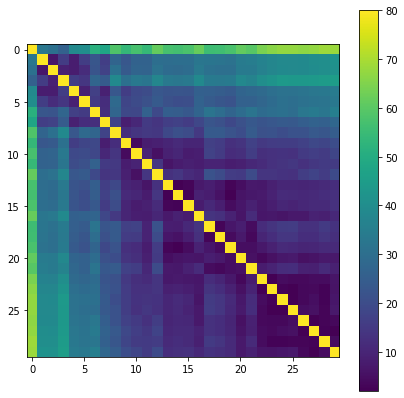

In [ ]:
plt.figure(figsize=(7,7))
plt.imshow(Me, cmap='viridis')
plt.colorbar()
plt.show()

In [ ]:
import hdbscan

# just for curiosity

matr = []
for l in d_matr.values():
    matr.append(l)
    

clusterer = hdbscan.HDBSCAN()
clusterer.fit(Me)

clusterer.labels_

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1])

Text(0, 0.5, 'Euclidean distance')

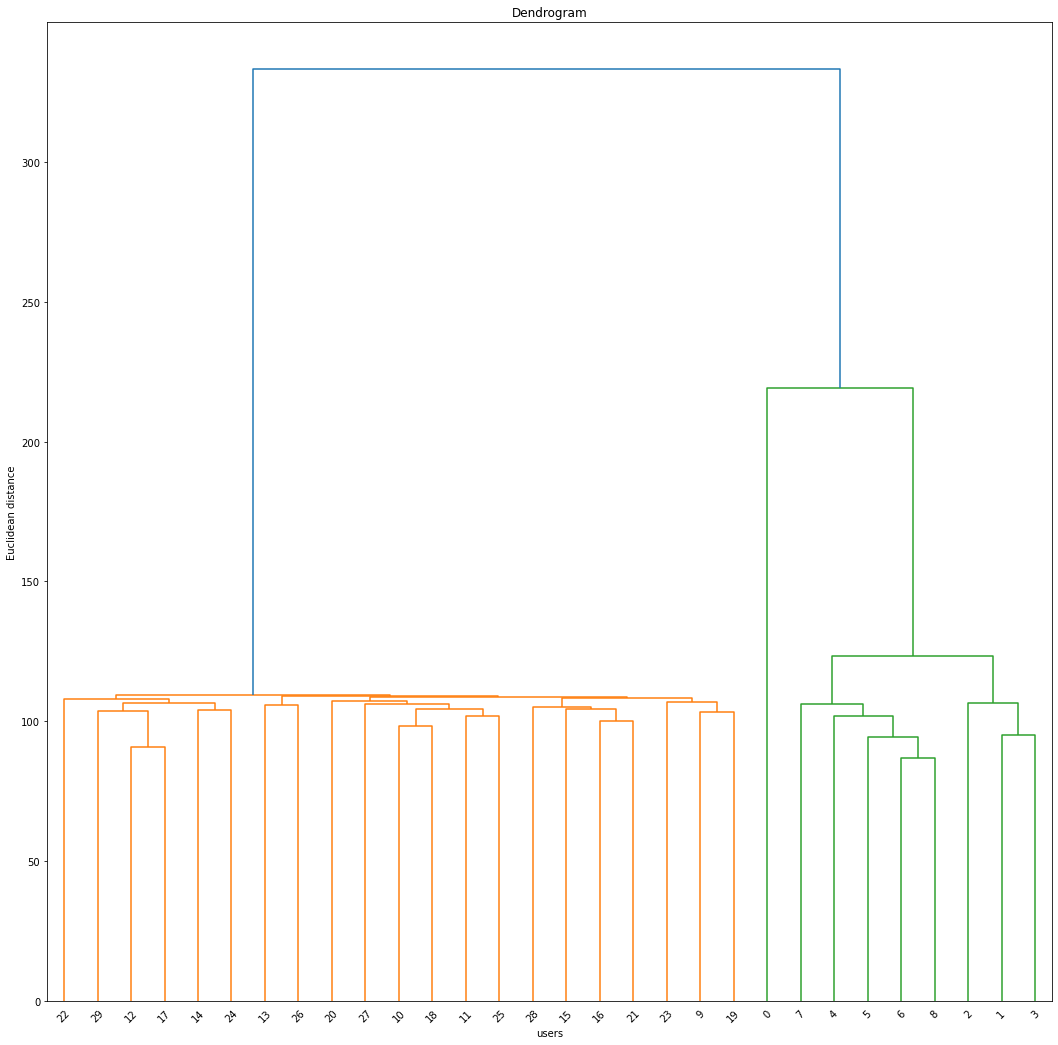

In [ ]:
plt.figure(figsize=(18,18))
Z1 = sch.linkage(Me, method = 'ward')
dendrogrm2 = sch.dendrogram(Z1)
plt.title('Dendrogram')
plt.xlabel('users')
plt.ylabel('Euclidean distance')

### graph based on cluster labels

[2 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


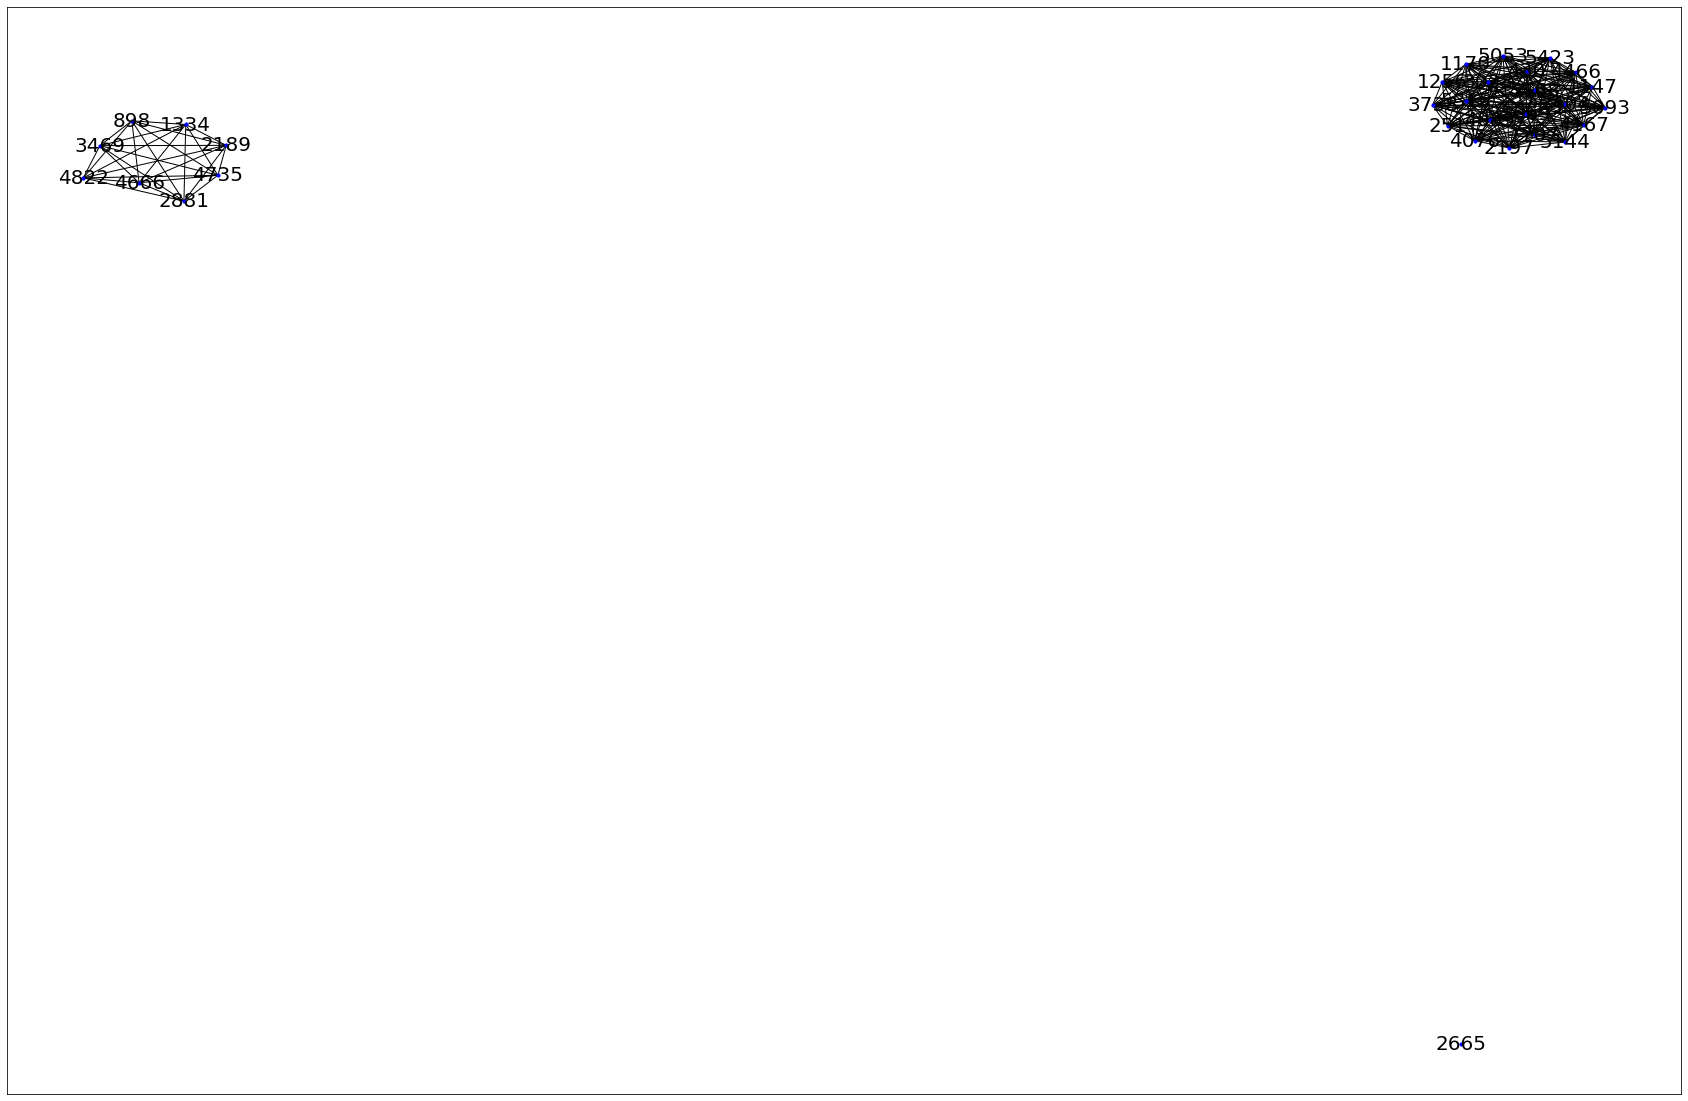

In [ ]:
model = hc = AgglomerativeClustering(n_clusters = None, affinity = 'euclidean', linkage = 'ward', distance_threshold = 200).fit(Me)
g0 = nx.Graph()

print(model.labels_)

for m in matricole:
    g0.add_node(m)
for i in range(len(model.labels_)):
    for j in range(len(model.labels_)):
        if model.labels_[i] == model.labels_[j]:
            g0.add_edge(matricole[i], matricole[j])

            
plt.figure(figsize=(30,20))
nx.draw_networkx(g0, node_size=10, node_color='blue', font_size=20)
plt.show()

nx.write_edgelist(g0, "test_edgelist_agglo.csv", delimiter=' ', data=['weight'])

### graph based on distance matrix

In [ ]:
Ge = nx.Graph()
for m in matricole:
    Ge.add_node(m)
for i in range(len(Me)):
    for j in range(len(Me[i])):
        if Me[i][j] <= 10:
            Ge.add_edge(matricole[i], matricole[j], wieght=Me[i][j])

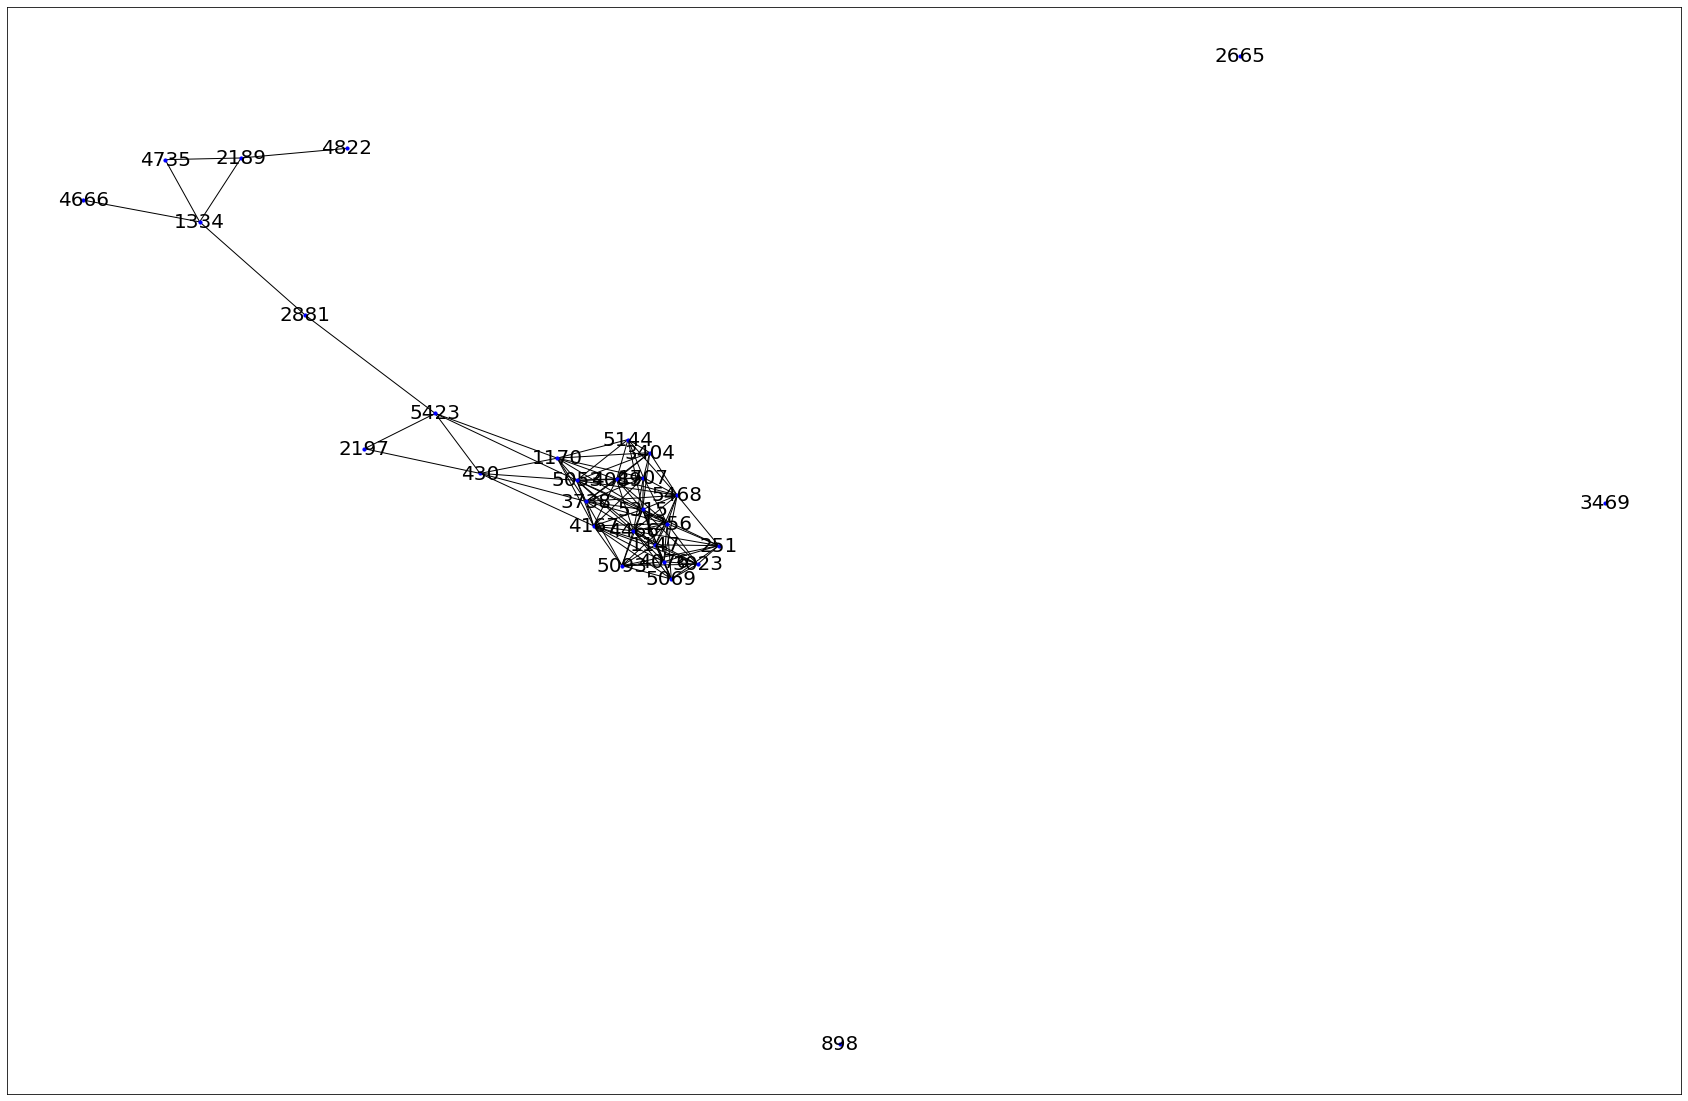

In [ ]:
plt.figure(figsize=(30,20))
nx.draw_networkx(Ge, node_size=10, node_color='blue', font_size=20)
plt.show()

nx.write_edgelist(Ge, "test_edgelist_distancematr.csv", delimiter=' ', data=['weight'])